In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cancer_cnn_model import CancerCNN

In [8]:
# Load the saved model
model = CancerCNN()
model.load_state_dict(torch.load('cancer_cnn.pth'))
model.eval()

# Define the data preprocessing for the input image
image_size = 224
normalization_mean = [0.5, 0.5, 0.5]
normalization_std = [0.5, 0.5, 0.5]

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(normalization_mean, normalization_std)
])

# Function to classify an image as benign or malignant
def classify_image(image_path, model):
    image = Image.open(image_path).convert("RGB")
    image = test_transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(image)
    probabilities = torch.softmax(output, dim=1)
    probability_malignant = probabilities[0][1].item()
    probability_benign = probabilities[0][0].item()

    if probability_malignant >= probability_benign:
        return "Malignant", probability_malignant
    else:
        return "Benign", probability_benign

In [9]:
test_image_folder = '/mnt/d/dev/JupyterProjects/Data/Cancer/benign-malignant/data/test/'

In [10]:
# Function to display an image with accuracy information
def display_image_with_accuracy(image_path, image_class, model, ax):
    result_class, result_prob = classify_image(image_path, model)
    image = Image.open(image_path)
    ax.imshow(image)
    ax.set_title("Class: {}, Prob: {:.4f}".format(result_class, result_prob))
    ax.axis('off')
    ax.text(10, image.size[1] - 20, "Prediction is Accurate: {}".format(result_class == image_class),
             bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

    return result_class == image_class

In [11]:
# Function to check random images with accuracy information and save plots to PDF
def check_random_images(image_folder, image_class, model, num_images=10, pdf_filename=None):
    image_paths = [f for f in os.listdir(image_folder) if not f.startswith('.gitkeep')]
    random_images = random.sample(image_paths, num_images)
    correct_count = 0
    total_count = 0

    plt.figure(figsize=(15, 6))
    for i, image_name in enumerate(random_images):
        image_path = os.path.join(image_folder, image_name)
        ax = plt.subplot(2, num_images // 2, i + 1)
        plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the horizontal and vertical spacing between subplots
        is_correct = display_image_with_accuracy(image_path, image_class, model, ax)
        correct_count += int(is_correct)
        total_count += 1

    accuracy = correct_count / total_count * 100
    plt.suptitle("{} Accuracy: {:.2f}%".format(image_class, accuracy))
    
    # Save the plot as a PDF if pdf_filename is provided
    if pdf_filename:
        plt.savefig(pdf_filename, format='pdf')

Checking random benign images...


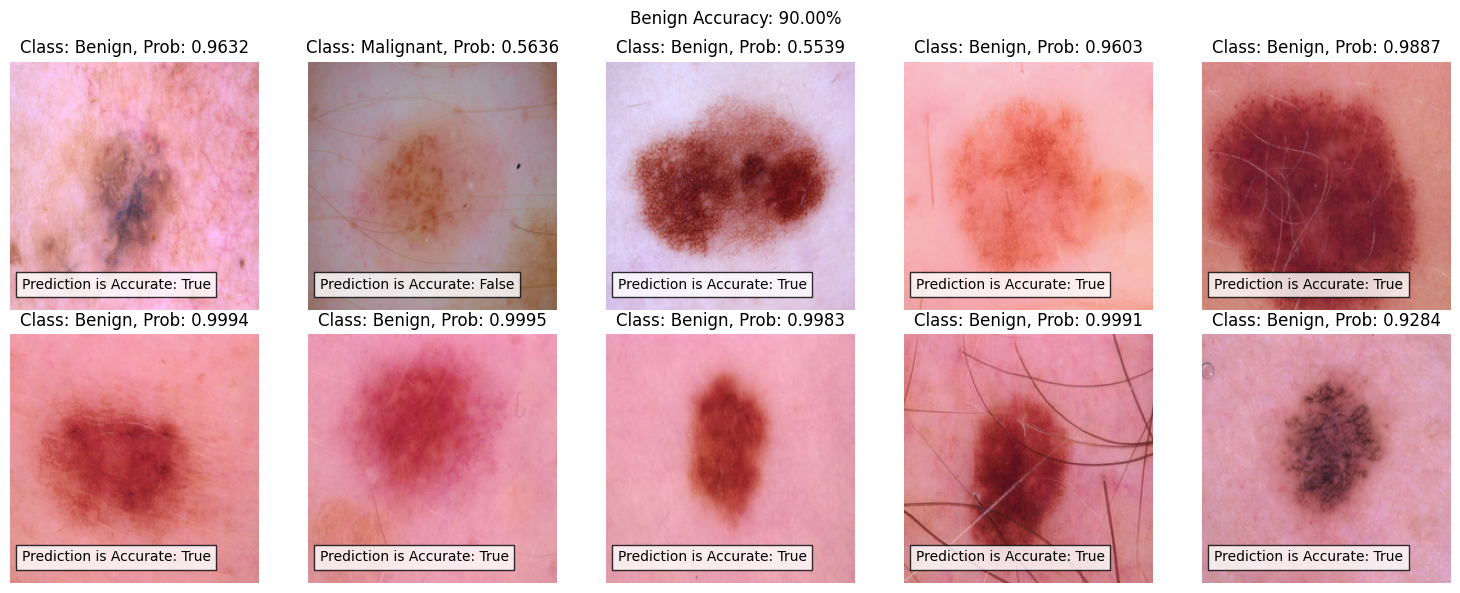

Checking random malignant images...


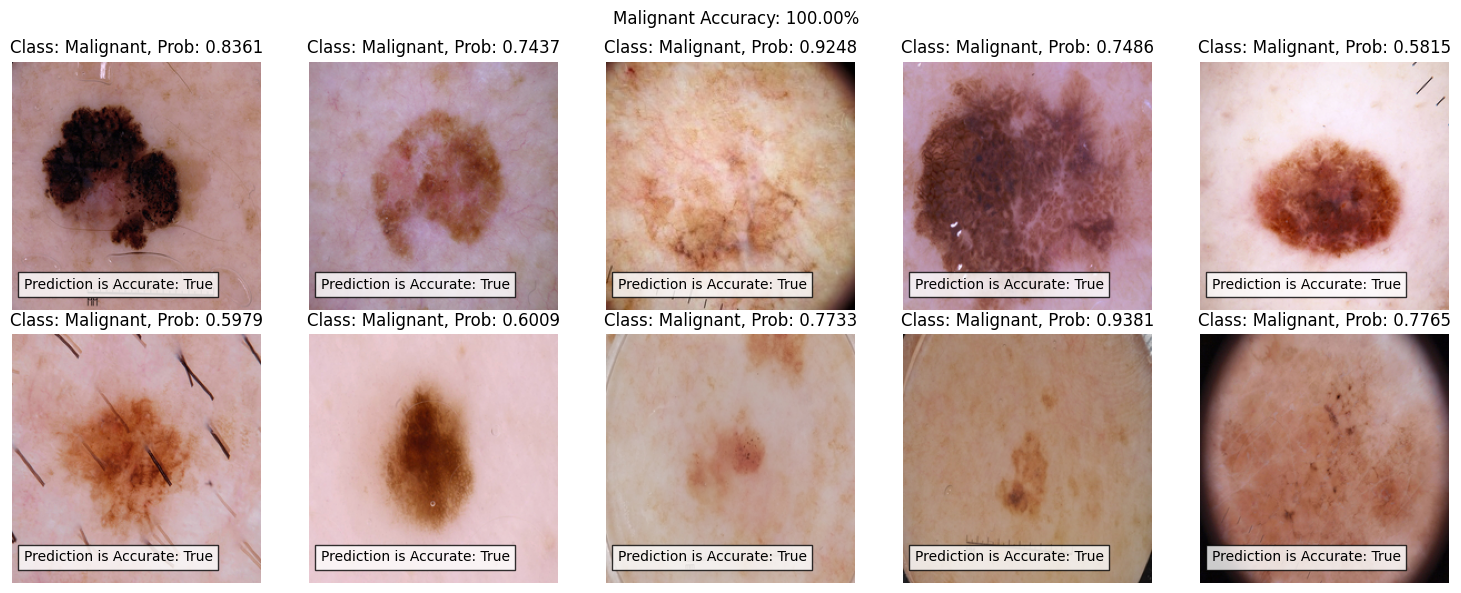

In [13]:
num_images=10

# Check random benign images with accuracy information and save the plot to PDF
print("Checking random benign images...")
check_random_images(os.path.join(test_image_folder, 'benign'), "Benign", model, num_images=10, pdf_filename='validation/benign_validation.pdf')
plt.tight_layout()
plt.show()

# Check random malignant images with accuracy information and save the plot to PDF
print("Checking random malignant images...")
check_random_images(os.path.join(test_image_folder, 'malignant'), "Malignant", model, num_images=10, pdf_filename='validation/malignant_validation.pdf')
plt.tight_layout()
plt.show()